In [1]:
import cv2
import numpy as np
import os
import concurrent.futures
import re
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import open3d as o3d

In [2]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

folder_path = r"path_to_the_images"
image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg') ]
image_files.sort(key=natural_keys) 
images = [cv2.imread(os.path.join(folder_path, f)) for f in image_files]

In [3]:
def process_image(detector, image):
    return detector.detectAndCompute(image, None)


def find_keypoints_and_matches(detector, images):
    keypoints = []
    descriptors = []

    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = executor.map(lambda img: process_image(detector, img), images)

    for kp, des in results:
        keypoints.append(kp)
        descriptors.append(des)

    return keypoints, descriptors

def match_features(descriptors, matcher, num_images, match_limit=5):   
    matches = {}

    for i in range(num_images):  
        matches[i] = []
        for j in range(i+1, min(i+1+match_limit, num_images)):  
            raw_matches = matcher.knnMatch(descriptors[i], descriptors[j], k=2) 
            good_matches = [m for m, n in raw_matches if m.distance < 0.7*n.distance]  
            if len(good_matches) > 0:
                matches[i].append((j, good_matches))    

    return matches

detector = cv2.SIFT_create()

In [4]:
keypoints, descriptors = find_keypoints_and_matches(detector, images)

bf = cv2.BFMatcher()
matches = match_features(descriptors, bf, len(images))

In [8]:
def estimate_fundamental_essential(keypoints, matches, K):                                   
    fundamental_matrices = {}
    essential_matrices = {}
    inlier_matches = {}  

    for i, match_info in matches.items():
        for j, good_matches in match_info:
            img1_pts = np.float32([keypoints[i][m.queryIdx].pt for m in good_matches])        
            img2_pts = np.float32([keypoints[j][m.trainIdx].pt for m in good_matches])
            
            F, mask = cv2.findFundamentalMat(img1_pts, img2_pts, cv2.FM_RANSAC)              

            if F is None or mask is None:
                print(f"Could not find a fundamental matrix for image pair ({i}, {j})")
                continue
            
            inlier_match = []
            img1_inlier_pts = []
            img2_inlier_pts = []
            for idx, inlier in enumerate(mask.ravel()):
                if inlier:
                    m = good_matches[idx]
                    inlier_match.append(m)
                    img1_inlier_pts.append(keypoints[i][m.queryIdx].pt)  
                    img2_inlier_pts.append(keypoints[j][m.trainIdx].pt)  

            img1_inlier_pts = np.array(img1_inlier_pts, dtype=np.float32)
            img2_inlier_pts = np.array(img2_inlier_pts, dtype=np.float32)        

            if len(inlier_match) < 1:
                print(f"Not enough inlier matches for image pair ({i}, {j})")
                continue      

            E, _ = cv2.findEssentialMat(img1_inlier_pts, img2_inlier_pts, K, cv2.RANSAC, 0.999, 1.0, mask=None)  

            fundamental_matrices[(i, j)] = F
            essential_matrices[(i, j)] = E
            inlier_matches[(i, j)] = inlier_match

    return fundamental_matrices, essential_matrices, inlier_matches

K = np.array([[3.06043255e+03, 0.00000000e+00, 1.51853189e+03],
              [0.00000000e+00, 3.06222050e+03, 1.98250647e+03],
              [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

fundamental_matrices, essential_matrices, inlier_matches = estimate_fundamental_essential(keypoints, matches, K)

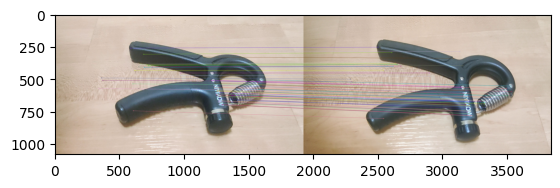

In [11]:
def visualize_inlier_matches(image1, keypoints1, image2, keypoints2, inlier_matches):
    matches_to_draw = []
    for m in inlier_matches:
        if m.queryIdx < len(keypoints1) and m.trainIdx < len(keypoints2):
            matches_to_draw.append(cv2.DMatch(_queryIdx=m.queryIdx, _trainIdx=m.trainIdx, _imgIdx=0, _distance=0))

    matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches_to_draw, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
    plt.show()

image1 = images[0]  
image2 = images[1]
keypoints1 = keypoints[0]
keypoints2 = keypoints[1]

inlier_match_data = inlier_matches.get((0, 1), [])

if inlier_match_data and isinstance(inlier_match_data[0], tuple):
    inlier_match_data = [cv2.DMatch(_queryIdx=idx[0], _trainIdx=idx[1], _imgIdx=0, _distance=0) for idx in inlier_match_data]

visualize_inlier_matches(image1, keypoints1, image2, keypoints2, inlier_match_data)

In [12]:
def decompose_essential_matrix(E, K, img1_pts, img2_pts):
    R1, R2, t = cv2.decomposeEssentialMat(E)

    possible_poses = [(R1, t), (R1, -t), (R2, t), (R2, -t)]

    for R, t in possible_poses:
        proj_matrix1 = np.hstack((np.eye(3), np.zeros((3, 1))))
        proj_matrix2 = np.hstack((R, t.reshape(3, 1)))

        points_3d = cv2.triangulatePoints(K @ proj_matrix1, K @ proj_matrix2, img1_pts.T, img2_pts.T)
        points_3d /= points_3d[3]

        if (np.mean(points_3d[2]) > 0) and (np.mean(R @ points_3d[:3] + t.reshape(3, 1)) > 0):
            return R, t

    return None, None 

triangulated_points = {}
camera_poses = {}
skipped_pairs = []

for (i, j), E in essential_matrices.items():
    img1_pts = np.float32([keypoints[i][m.queryIdx].pt for m in inlier_matches[(i, j)]])
    img2_pts = np.float32([keypoints[j][m.trainIdx].pt for m in inlier_matches[(i, j)]])

    R, t = decompose_essential_matrix(E, K, img1_pts, img2_pts)
    
    if R is None or t is None:
        skipped_pairs.append((i, j))
        continue

    camera_poses[(i, j)] = (R, t)

    proj_matrix1 = np.hstack((np.eye(3), np.zeros((3, 1))))
    proj_matrix2 = np.hstack((R, t.reshape(3, 1)))
    points_3d = cv2.triangulatePoints(K @ proj_matrix1, K @ proj_matrix2, img1_pts.T, img2_pts.T)
    points_3d /= points_3d[3]  

    triangulated_points[(i, j)] = points_3d[:3] 

In [14]:
def bundle_adjustment(camera_poses, triangulated_points, keypoints, matches, K):
    camera_params = np.hstack([np.hstack((R.ravel(), t.ravel())) for (R, t) in camera_poses.values()])
    all_points_3d = np.hstack([points.T.ravel() for points in triangulated_points.values()])
    num_points = all_points_3d.size // 3

    x0 = np.hstack((camera_params, all_points_3d))

    num_cameras = len(camera_poses)

    expected_x0_size = 12 * num_cameras + 3 * num_points
    if x0.size != expected_x0_size:
        raise ValueError(f"Size mismatch in x0: expected {expected_x0_size}, got {x0.size}")
    

    def objective_function(x, keypoints, matches, K, num_cameras, num_points):
        cameras = x[:12 * num_cameras].reshape(-1, 12)
        points = x[12 * num_cameras:].reshape(-1, 3)

        error = []
        point_idx = 0
        for i, match_info in matches.items():
            for j, good_matches in match_info:
                if (i, j) not in camera_poses:
                    continue

                camera_index_i = list(camera_poses.keys()).index((i, j))
                R_i, t_i = cameras[camera_index_i, :9].reshape(3, 3), cameras[camera_index_i, 9:12]
                P_i = K @ np.hstack((R_i, t_i.reshape(3, 1)))

                if (j, i) in camera_poses:
                    camera_index_j = list(camera_poses.keys()).index((j, i))
                    R_j, t_j = cameras[camera_index_j, :9].reshape(3, 3), cameras[camera_index_j, 9:12]
                else:
                    R_j, t_j = np.linalg.inv(R_i), -np.linalg.inv(R_i) @ t_i
                    P_j = K @ np.hstack((R_j, t_j.reshape(3, 1)))

                for m_idx, m in enumerate(good_matches):
                    if point_idx + m_idx >= num_points:
                        break 

                    point_2d_i = np.array(keypoints[i][m.queryIdx].pt)
                    point_2d_j = np.array(keypoints[j][m.trainIdx].pt)

                    point_3d = points[point_idx]
                    projected_i = P_i @ np.hstack((point_3d, 1))
                    projected_i /= projected_i[2]

                    projected_j = P_j @ np.hstack((point_3d, 1))
                    projected_j /= projected_j[2]
                    error.append(point_2d_i - projected_i[:2])
                    error.append(point_2d_j - projected_j[:2])

                point_idx += len(good_matches)    

        return np.array(error).ravel()            
    
    result = least_squares(objective_function, x0, args=(keypoints, matches, K, num_cameras, num_points), max_nfev=1)

    optimized_cameras = result.x[:12*len(camera_poses)].reshape(-1, 12)
    optimized_points = result.x[12*len(camera_poses):].reshape(-1, 3)

    return optimized_cameras, optimized_points

optimized_cameras, optimized_points = bundle_adjustment(camera_poses, triangulated_points, keypoints, matches, K)

In [16]:
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(optimized_points)
o3d.visualization.draw_geometries([point_cloud])
o3d.io.write_point_cloud("output_point_cloud.ply", point_cloud)

True